In [1]:
import sys
import os
import logging

# Add parent directory to Python path
parent_dir = os.path.abspath('..')  # This goes up one level to intraday-momentum
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Now import
from src.classes.data.loader import DataLoader

# Configure logging to show only INFO level and above
# Use the class method to set log level
DataLoader.set_log_level(logging.INFO)

In [2]:
loader = DataLoader()

ticker = 'SPY'
from_date = '2022-05-09'
until_date = '2024-04-22'

# Fetch intraday (minute) data
spy_intra_data, spy_intra_meta = loader.fetch_ohlcv_data(
    ticker=ticker,
    start_date=from_date,
    end_date=until_date,
    period='minute',
    adjusted=True,
    trading_hours=('09:30', '16:00')
)

# Fetch daily data
spy_daily_data, spy_daily_meta = loader.fetch_ohlcv_data(
    ticker=ticker,
    start_date=from_date,
    end_date=until_date,
    period='day',
    adjusted=True
)

# Fetch dividend data
spy_dividends, spy_dividends_meta = loader.fetch_dividend_data(
    ticker=ticker,
    start_date=from_date,
    end_date=until_date
)

print(f"Data fetched: {len(spy_intra_data):,} min bars, {len(spy_daily_data):,} daily bars, {len(spy_dividends):,} dividends")

INFO [2025-12-05 17:54:10] DataLoader initialized with rate limit: 5 requests/60s
INFO [2025-12-05 17:54:10] Fetching SPY OHLCV data: 2022-05-09 → 2024-04-22 (minute, adjusted=True)
INFO [2025-12-05 17:54:18] Saved raw data to data\raw\SPY_1min_20220509_20240422.csv.gz
INFO [2025-12-05 17:54:18] Fetched 36,754 entries for SPY (elapsed: 6.1s)
INFO [2025-12-05 17:54:18] Fetching SPY OHLCV data: 2022-05-09 → 2024-04-22 (day, adjusted=True)
INFO [2025-12-05 17:54:18] Saved raw data to data\raw\SPY_1day_20220509_20240422.csv
INFO [2025-12-05 17:54:18] Fetched 94 entries for SPY (elapsed: 0.4s)
INFO [2025-12-05 17:54:18] Fetching dividend data for SPY
INFO [2025-12-05 17:54:19] Saved dividend data to data\dividends\SPY_dividends_2022-05-09_2024-04-22.csv
INFO [2025-12-05 17:54:19] Fetched 8 dividend records for SPY (elapsed: 0.4s)


Data fetched: 36,754 min bars, 94 daily bars, 8 dividends


In [11]:
# Run all available checks from loader

print("=" * 60)
print("VALIDATION CHECKS")
print("=" * 60)

# 1. Validate calendar for daily data
print("\n1. Daily Data Calendar Validation:")
daily_calendar_check = loader.validate_calendar(spy_daily_data, frequency='daily')
for key, value in daily_calendar_check.items():
    print(f"   {key}: {value}")

# 2. Validate calendar for intraday data
print("\n2. Intraday Data Calendar Validation:")
intraday_calendar_check = loader.validate_calendar(spy_intra_data, frequency='minute')
for key, value in intraday_calendar_check.items():
    if key == 'interval_statistics':
        print(f"   {key}:")
        for stat_key, stat_value in value.items():
            print(f"      {stat_key}: {stat_value}")
    elif key == 'daily_statistics':
        print(f"   {key}:")
        for stat_key, stat_value in value.items():
            print(f"      {stat_key}: {stat_value}")
    else:
        print(f"   {key}: {value}")

# 3. Check dataframe alignment between intraday and daily
print("\n3. DataFrame Alignment Check:")
alignment_check = loader.check_dataframe_alignment([spy_intra_data, spy_daily_data])
for key, value in alignment_check.items():
    if key == 'details':
        print(f"   {key}:")
        for detail_key, detail_value in value.items():
            print(f"      {detail_key}: {detail_value}")
    else:
        print(f"   {key}: {value}")

# 4. Rate limit status
print("\n4. Rate Limit Status:")
rate_status = loader.get_rate_limit_status()
for key, value in rate_status.items():
    print(f"   {key}: {value}")

print("\n" + "=" * 60)

VALIDATION CHECKS

1. Daily Data Calendar Validation:
   total_entries: 94
   unique_dates: 94
   date_range: (datetime.date(2023, 12, 6), datetime.date(2024, 4, 22))
   frequency: daily
   expected_business_days: 99
   actual_business_days: 94
   weekend_days: 0
   missing_days_count: 5
   missing_days: [datetime.date(2023, 12, 25), datetime.date(2024, 1, 1), datetime.date(2024, 1, 15), datetime.date(2024, 2, 19), datetime.date(2024, 3, 29)]
   coverage_percentage: 94.95
   status: incomplete

2. Intraday Data Calendar Validation:
   total_entries: 36754
   unique_dates: 94
   date_range: (datetime.date(2023, 12, 6), datetime.date(2024, 4, 22))
   frequency: minute
   interval_statistics:
      min_interval_seconds: 60.0
      max_interval_seconds: 322200.0
      median_interval_seconds: 60.0
      mean_interval_seconds: 324.953065
      std_interval_seconds: 6674.763022
   daily_statistics:
      min_entries_per_day: 391
      max_entries_per_day: 391
      mean_entries_per_day: 391.

In [12]:
# Import DataCleaner
from src.classes.data.cleaner import DataCleaner

print("=" * 60)
print("DATA CLEANING")
print("=" * 60)

# Clean intraday (minute) data
print("\n1. Cleaning intraday (minute) data...")
intra_filepath = str(spy_intra_meta['filepath'])
intra_cleaner = DataCleaner(intra_filepath)

print(f"   BEFORE cleaning:")
print(f"      Shape: {intra_cleaner.df.shape}")
print(f"      Columns: {list(intra_cleaner.df.columns)}")
missing_before = intra_cleaner.compute_missing_ratio()
print(f"      Missing values: {missing_before.sum():.0f} total")
for col, ratio in missing_before.items():
    if ratio > 0:
        print(f"         {col}: {ratio:.2%}")

intra_cleaner.clean()
intra_cleaner.fill_nan('close')

print(f"   AFTER cleaning:")
print(f"      Shape: {intra_cleaner.df.shape}")
print(f"      Index type: {type(intra_cleaner.df.index).__name__}")
print(f"      Date range: {intra_cleaner.df.index.min()} to {intra_cleaner.df.index.max()}")
missing_after = intra_cleaner.compute_missing_ratio()
print(f"      Missing values: {missing_after.sum():.0f} total")

# Clean daily data
print("\n2. Cleaning daily data...")
daily_filepath = str(spy_daily_meta['filepath'])
daily_cleaner = DataCleaner(daily_filepath)

print(f"   BEFORE cleaning:")
print(f"      Shape: {daily_cleaner.df.shape}")
print(f"      Columns: {list(daily_cleaner.df.columns)}")
missing_before = daily_cleaner.compute_missing_ratio()
print(f"      Missing values: {missing_before.sum():.0f} total")
for col, ratio in missing_before.items():
    if ratio > 0:
        print(f"         {col}: {ratio:.2%}")

daily_cleaner.clean()
daily_cleaner.fill_nan('close')

print(f"   AFTER cleaning:")
print(f"      Shape: {daily_cleaner.df.shape}")
print(f"      Index type: {type(daily_cleaner.df.index).__name__}")
print(f"      Date range: {daily_cleaner.df.index.min()} to {daily_cleaner.df.index.max()}")
missing_after = daily_cleaner.compute_missing_ratio()
print(f"      Missing values: {missing_after.sum():.0f} total")

print("\n" + "=" * 60)
print("CLEANING COMPLETE")
print("=" * 60)

DATA CLEANING

1. Cleaning intraday (minute) data...
   BEFORE cleaning:
      Shape: (36754, 6)
      Columns: ['volume', 'open', 'high', 'low', 'close', 'caldt']
      Missing values: 0 total
   AFTER cleaning:
      Shape: (36754, 5)
      Index type: DatetimeIndex
      Date range: 2023-12-06 14:30:00+00:00 to 2024-04-22 20:00:00+00:00
      Missing values: 0 total

2. Cleaning daily data...
   BEFORE cleaning:
      Shape: (94, 6)
      Columns: ['volume', 'open', 'high', 'low', 'close', 'caldt']
      Missing values: 0 total
   AFTER cleaning:
      Shape: (94, 5)
      Index type: DatetimeIndex
      Date range: 2023-12-06 05:00:00+00:00 to 2024-04-22 04:00:00+00:00
      Missing values: 0 total

CLEANING COMPLETE


DATA VISUALIZATION

1. Plotting intraday (minute) data...


c:\Users\giuli\Repositories\intraday-momentum\src\classes\data\cleaner.py:223: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend(loc='lower left')


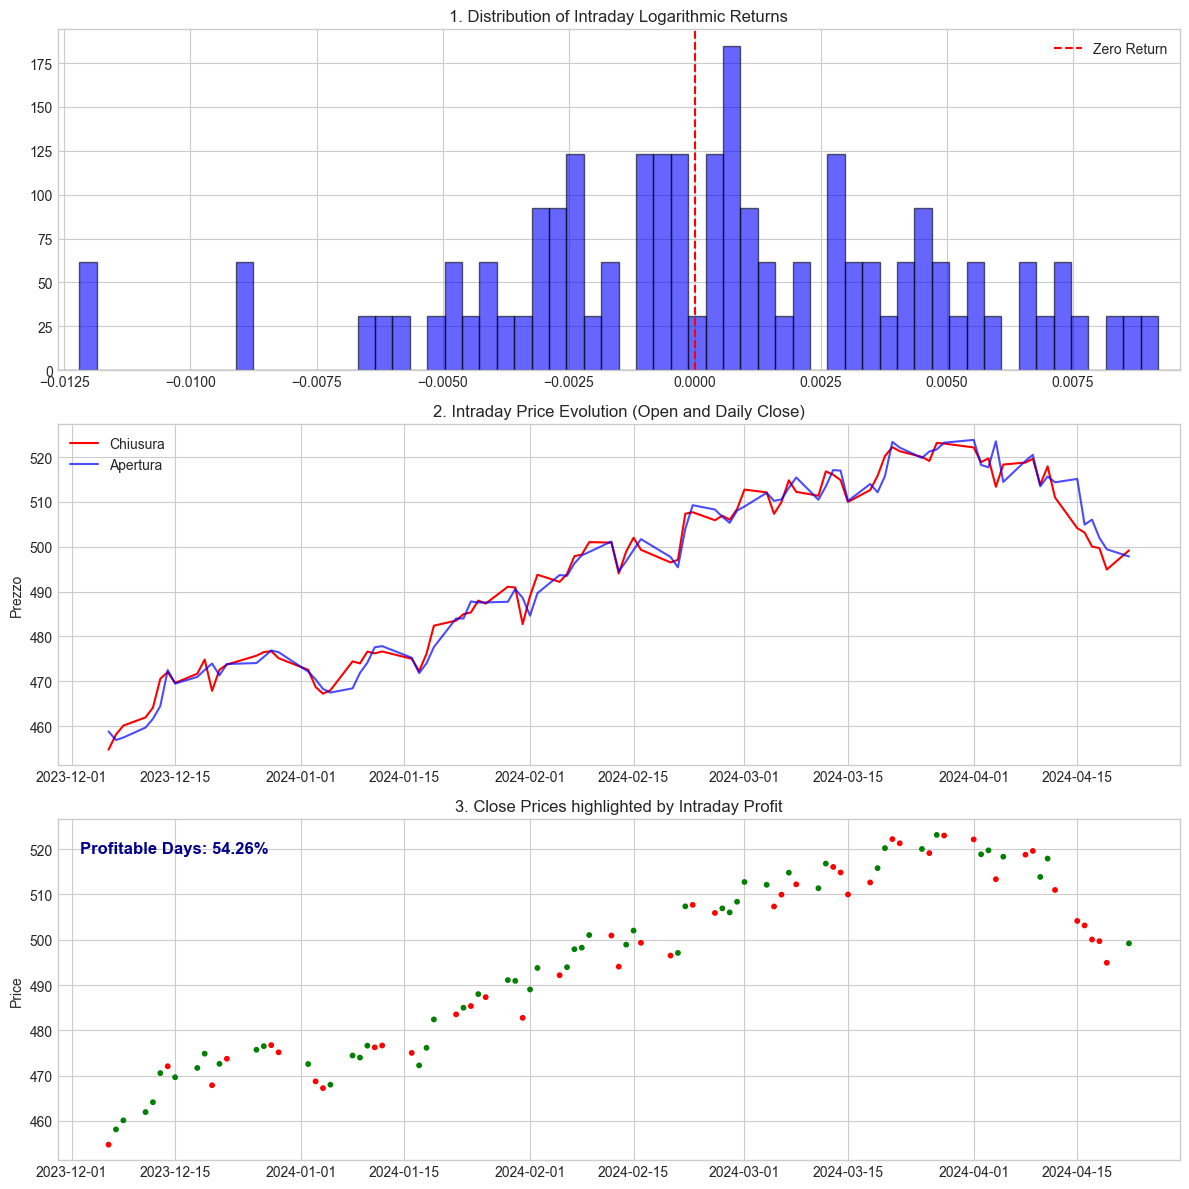

   Intraday plot generated successfully

2. Plotting daily data...


c:\Users\giuli\Repositories\intraday-momentum\src\classes\data\cleaner.py:223: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend(loc='lower left')


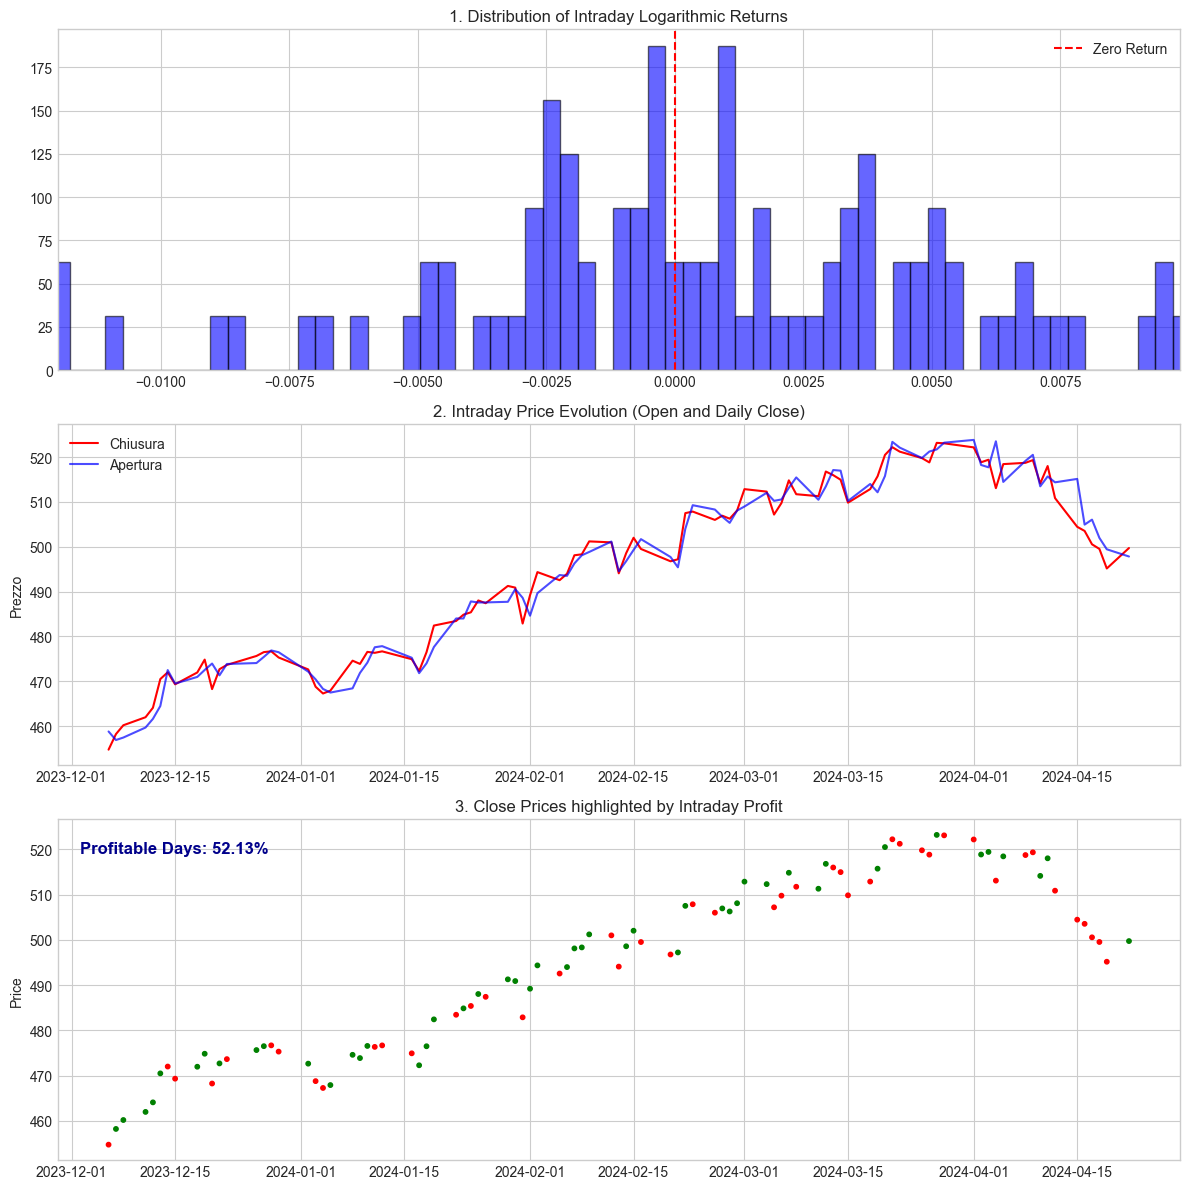

   Daily plot generated successfully



In [14]:
# Plot cleaned data
print("=" * 60)
print("DATA VISUALIZATION")
print("=" * 60)

print("\n1. Plotting intraday (minute) data...")
try:
    intra_cleaner.plot()
    print("   Intraday plot generated successfully")
except Exception as e:
    print(f"   Error plotting intraday data: {e}")

print("\n2. Plotting daily data...")
try:
    daily_cleaner.plot()
    print("   Daily plot generated successfully")
except Exception as e:
    print(f"   Error plotting daily data: {e}")

print("\n" + "=" * 60)

In [17]:
intra_cleaner.save_cleaned(filename= "intraday_sp500")
daily_cleaner.save_cleaned(filename= "daily_sp500")


INFO: Object successfully pickled and saved to: C:\Users\giuli\Repositories\intraday-momentum\data\cleaned\intraday_sp500.pkl
INFO: Object successfully pickled and saved to: C:\Users\giuli\Repositories\intraday-momentum\data\cleaned\daily_sp500.pkl
